> Reference:
> 
> Unveiling the Power of Projected Gradient Descent in Adversarial Attacks: https://medium.com/@zachariaharungeorge/unveiling-the-power-of-projected-gradient-descent-in-adversarial-attacks-2f92509dde3c
> 
> Working with Results: https://docs.ultralytics.com/modes/predict/#working-with-results
> 
> Understanding output of .pt file of YOLOv8: https://github.com/ultralytics/ultralytics/issues/8421

# Issues (fixed)
In the `pgd_attack(model, images, labels, epsilon, alpha, num_iterations)` funtion, the outputs of `model(perturbed_images)` is a list. It's make sense since in the Ultralytics documentation`All Ultralytics predict() calls will return a list of Results objects`. However, the `CrossEntropyLoss()` here requires `argument 'input' (position 1) must be Tensor, not list`. I then check the above Github issues, seems like every pre-trained YOLOv8 model will return different result format. Not sure about YOLOv8 underlying way of handling output.

**Solution**: use the `classify_model` which includes the backbone, instead of using the YOLOv8 model directly.

# Working Mechanism of Projected Gradient Descent (PGD)

At the core of machine learning optimization lies the fundamental concept of gradient descent. This iterative algorithm fine-tunes model parameters to minimize a given loss function. Mathematically, the update rule is expressed as:

$$\Theta_{t+1} = \Theta_t - \alpha \cdot \nabla J(\Theta_t)$$

where $\Theta_t$ represents the parameters at iteration $t$, $\alpha$ is the learning rate, and $\nabla J(\Theta_t)$ is the gradient of the loss function.

## Projected Gradient Descent (PGD)

Projected Gradient Descent (PGD) builds upon this foundation, introducing thoughtful constraints to enhance its effectiveness in crafting adversarial examples. In the context of adversarial attacks, the objective is to perturb input data to deliberately mislead the model.

PGD incorporates a perturbation budget ($\epsilon$) and a step size ($\alpha$) to control the amount and direction of perturbation. The update rule for PGD is defined as:

$$x'_{t+1} = \Pi(x_t + \alpha \cdot \text{sign}(\nabla_x J(\Theta, x_t, y)))$$

where $x_t$​ is the input at iteration $t$, $\alpha$ is the step size, $\nabla_x J(\Theta, x_t, y)$ is the gradient of the loss with respect to the input, and $\Pi$​ is the projection operator ensuring perturbed input stays within predefined bounds.


In [ ]:
! pip install ultralytics

In [118]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image



# Step 1: Load trained YOLOv8 model
model = YOLO('train/weights/best.pt')
image_path = 'stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

Implement Projected Gradient Descent (PGD) here.

In [119]:
# Projected Gradient Descent (PGD) Attack Function
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    perturbed_image = images.clone()
    perturbed_image.requires_grad = True
    
    for _ in range(num_iter):
        outputs = model(perturbed_image)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()  # Compute gradients with respect to input images
        
        # Update the perturbation using the sign of the gradient
        grad_sign = perturbed_image.grad.data.sign()
        perturbed_image = perturbed_image + alpha * grad_sign
        
        # Project the perturbed image to ensure it's within the epsilon-ball of the original image
        perturbation = torch.clamp(perturbed_image - images, -epsilon, epsilon)
        perturbed_image = torch.clamp(images + perturbation, 0, 1)  # Ensure pixel values are in [0, 1]
        
        # Detach and re-attach to clear previous gradient
        perturbed_image = perturbed_image.detach()
        perturbed_image.requires_grad = True
    
    return perturbed_image

# Example usage
epsilon = 0.03
alpha = 0.01
num_iter = 10
perturbed_image_pgd = pgd_attack(classify_model, image, labels, epsilon, alpha, num_iter)

In [120]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

perturbed_image_pgd = torch.clamp(perturbed_image_pgd, 0, 1)
image = torch.clamp(image, 0, 1)
boxes, scores, labels = get_yolo_output(model, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(model, perturbed_image_pgd)



0: 416x416 1 Stop_Sign, 73.7ms
Speed: 0.0ms preprocess, 73.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 67.7ms
Speed: 0.0ms preprocess, 67.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


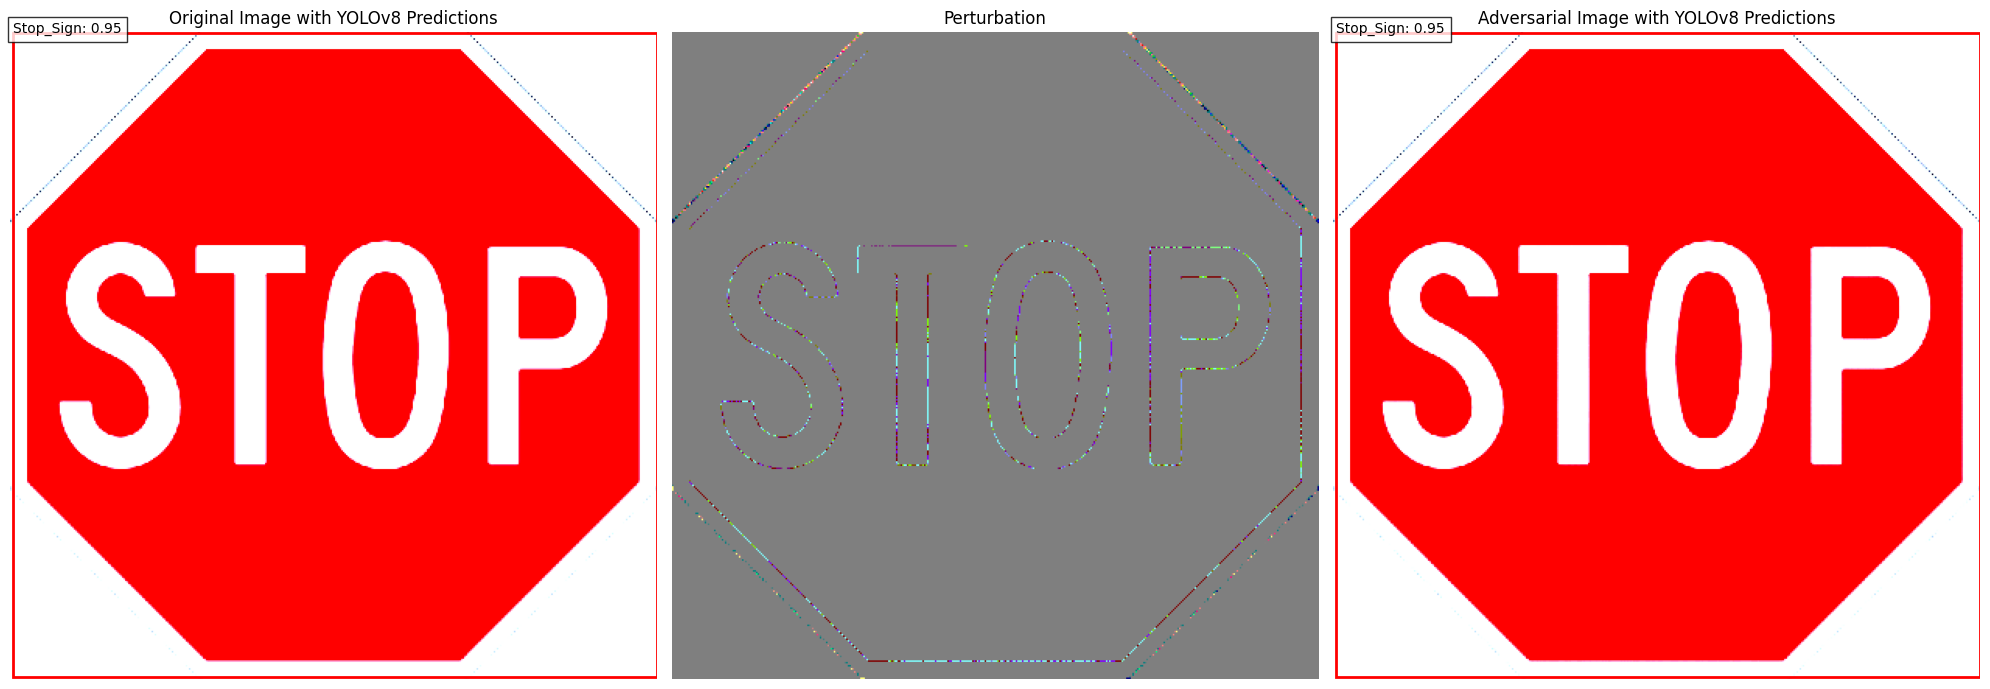

In [121]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image)

# Perturbation
perturbation = (perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image_pgd)

plt.tight_layout()
plt.show()
